In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

import numpy as np
import pandas as pd
import sqlalchemy as sqa

from jax.random import PRNGKey
import jax.numpy as jnp
from jax import random

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import scenario_generator.utils as u
import cel_utils.disk_utils as du

import gas_models

In [3]:
training_start_date = date(2022, 12, 1)  # this corresponds to the date that FIP45 was passed, which changed how much gas PSD messages took
training_end_date = date.today()-timedelta(days=3)

full_df = gas_models.get_daily_gasusage_training_data(training_start_date, training_end_date)

# train/test split
n_samp = len(full_df)
n_train = int(n_samp * 0.7)

train_df = full_df.iloc[0:n_train]
test_df = full_df.iloc[n_train:]

num_mc = 500

In [4]:
full_df.head()

,stat_date,total_gas_used,provecommit_sector_gas_used,precommit_sector_gas_used,provecommit_aggregate_gas_used,precommit_sector_batch_gas_used,publish_storage_deals_gas_used,submit_windowed_post_gas_used,date,day_onboarded_rb_power_pib,...,total_qa_power_eib,rb_renewal_rate,day_renewed_qa_power_pib,day_renewed_rb_power_pib,fpr,day_onboarded_deal_power,network_qa_rb_ratio,precommitx_sector_gas_used,provecommitx_sector_gas_used,total_minus_directfilp
0,2022-12-01T00:00:00Z,47669602126167,6946921288931,5473800854866,4173581349773,1218855229834,13390461427535,11093536613536,2022-12-01,4.900513,...,18.637933,0.622071,32.129242,32.129242,0.826182,2.588095,1.219122,6692656084700,11120502638704,16465981975228
1,2022-12-02T00:00:00Z,45607885065483,9307313574487,5489882794848,1976727065402,877822198281,11838746143109,10828102503580,2022-12-02,5.463226,...,18.786623,0.671110,32.095942,32.094513,0.784087,2.204414,1.220607,6367704993129,11284040639889,16117393289356
2,2022-12-03T00:00:00Z,44431816043360,11293222469159,8832805859531,13333315382,119246934388,11203538398130,8766646324191,2022-12-03,5.796570,...,18.916621,0.688499,34.813684,34.813599,0.742567,1.857804,1.220888,8952052793919,11306555784541,12969669066770
3,2022-12-04T00:00:00Z,41150077997254,11346935334084,9689904658983,2116221197,74609249,10762030982806,7149476871990,2022-12-04,5.967133,...,18.957937,0.702883,43.277560,43.273499,0.744504,1.931995,1.222423,9689979268232,11349051555281,9349016190935
4,2022-12-05T00:00:00Z,42849385237355,10859472903098,9986979799607,0,0,10074386059308,6842666672362,2022-12-05,5.757080,...,18.974549,0.665862,36.031763,36.031616,0.735682,1.780421,1.223778,9986979799607,10859472903098,11928546475342


In [5]:
# Total Gas Usage Model
totalgas_model = gas_models.ArimaxGasModel('total', log_after_scaler=True)
r = totalgas_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.0022
Acceptance rate of Metropolis-Hastings is 0.2031
Acceptance rate of Metropolis-Hastings is 0.2728

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.260425
Normal ARIMAX(4,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 4                                           Unnormalized Log Posterior: 903.7622              
End Date: 207                                           AIC: -1775.5244314138422                          
Number of observations: 204                             BIC: -1722.4345115123347                          
Latent Variable                          Median             Mean               95%

In [6]:
# Total-DirectFILP Model
total_minus_directfilp_model = gas_models.ArimaxGasModel('total_minus_directfilp', log_after_scaler=True)
r = total_minus_directfilp_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.003275
Acceptance rate of Metropolis-Hastings is 0.20745
Acceptance rate of Metropolis-Hastings is 0.269375

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.26465
Normal ARIMAX(1,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: total_minus_directfilp              Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 805.173               
End Date: 207                                           AIC: -1584.345942979399                           
Number of observations: 207                             BIC: -1541.0205986669494                          
Latent Variable                          Median             Mean              

In [7]:
# PSD Model
psd_model = gas_models.ArimaxGasModel('psd', log_after_scaler=True)
r = psd_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.03545
Acceptance rate of Metropolis-Hastings is 0.286875

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2829625
Normal ARIMAX(0,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 807.8012              
End Date: 207                                           AIC: -1605.6024403065417                          
Number of observations: 207                             BIC: -1588.938846340215                           
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ========

In [8]:
# PreCommitX model
precommitx_model = gas_models.ArimaxGasModel('precommitx', log_after_scaler=True)
r = precommitx_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.001675
Acceptance rate of Metropolis-Hastings is 0.192675
Acceptance rate of Metropolis-Hastings is 0.248475

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.249
Normal ARIMAX(1,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 934.6721              
End Date: 207                                           AIC: -1843.3442018090393                          
Number of observations: 207                             BIC: -1800.0188574965896                          
Latent Variable                          Median             Mean               

In [9]:
# ProveCommitX model
provecommitx_model = gas_models.ArimaxGasModel('provecommitx', log_after_scaler=True)
r = provecommitx_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.000575
Acceptance rate of Metropolis-Hastings is 0.116475
Acceptance rate of Metropolis-Hastings is 0.16955
Acceptance rate of Metropolis-Hastings is 0.2155
Acceptance rate of Metropolis-Hastings is 0.273475

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.28145
Normal ARIMAX(1,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 954.2538              
End Date: 207                                           AIC: -1890.5075715548737                          
Number of observations: 206                             BIC: -1860.5566860357676                          
Latent Variable         

In [10]:
ypred_total = totalgas_model.forecast(test_df, num_mc)
ypred_total_minus_directfilp = total_minus_directfilp_model.forecast(test_df, num_mc)  
ypred_psd = psd_model.forecast(test_df, num_mc)
ypred_precommitx = precommitx_model.forecast(test_df, num_mc)
ypred_provecommitx = provecommitx_model.forecast(test_df, num_mc)

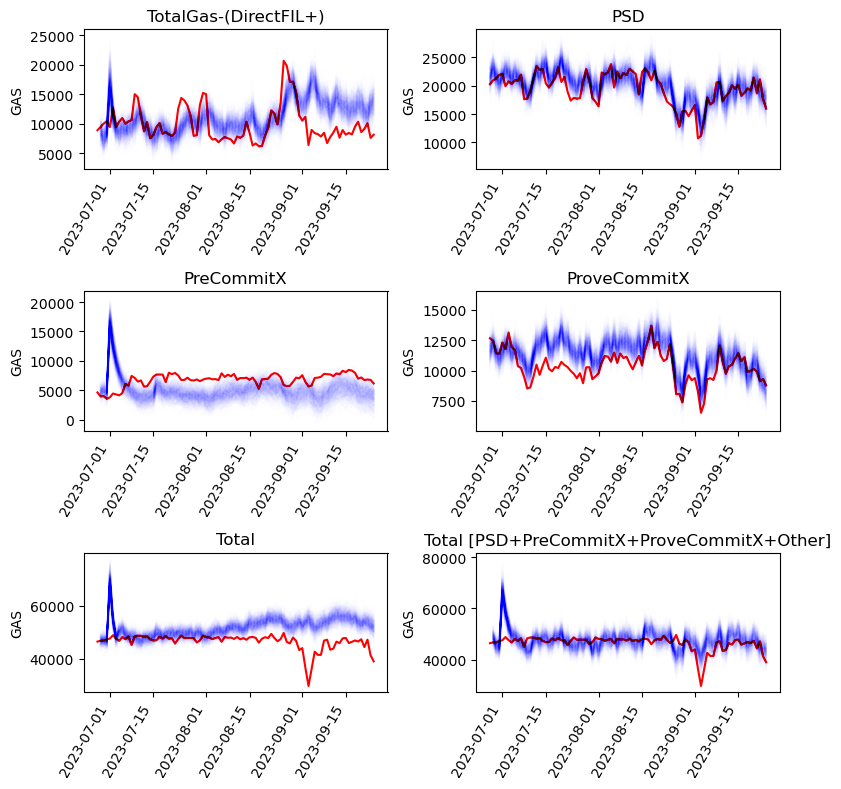

In [30]:
scale=1e-9
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,8))

axx = ax[0,0]
axx.plot(test_df['date'], test_df['total_minus_directfilp']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_total_minus_directfilp[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('TotalGas-(DirectFIL+)')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[0,1]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_psd[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('PSD')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,0]
axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_precommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('PreCommitX')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,1]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_provecommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ProveCommitX')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[2,0]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_total[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('Total')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

# show the total computed by summing the parts, vs. the ground-truth
axx = ax[2,1]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    y1 = ypred_total_minus_directfilp[ii,:]
    y2 = ypred_psd[ii,1:]
    y3 = ypred_precommitx[ii,:]
    y4 = ypred_provecommitx[ii,1:]
    yy = (y1+y2+y3+y4)*scale
    axx.plot(test_df['date'].iloc[1:], yy, color='b', alpha=0.005, label=l)
axx.set_title('Total [PSD+PreCommitX+ProveCommitX+Other]')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')


plt.tight_layout()